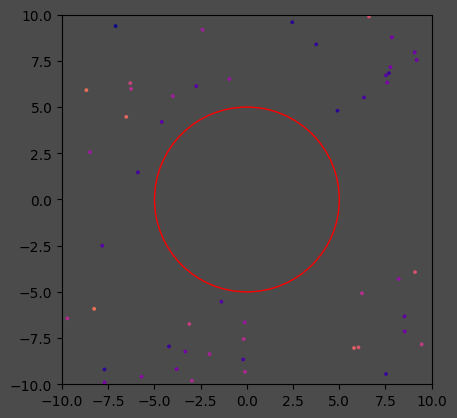

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Constants
NUM_PARTICLES = 5000  # Number of particles
TIME_STEP = 0.1
PARTICLE_RADIUS = 0.1  # Reduced particle radius
CIRCLE_CENTER = np.array([0, 0])
CIRCLE_RADIUS = 5
SQUARE_BOUNDARY = 10  # Half-width and half-height of the square
FRAME_COUNT = 300  # Number of frames

# Initialize particles
particles = {
    # Position particles evenly along the left side
    'position': np.column_stack((
        np.full(NUM_PARTICLES, -SQUARE_BOUNDARY + PARTICLE_RADIUS),  # x-coordinates
        np.linspace(-SQUARE_BOUNDARY, SQUARE_BOUNDARY, NUM_PARTICLES)  # y-coordinates
    )),
    'velocity': np.abs(np.random.randn(NUM_PARTICLES, 2)) * [1, 0] + [0.5, 0]
}

# Normalize for color mapping
norm = Normalize()
color_map = cm.plasma

def update_particles(particles):
    # Update particle positions
    particles['position'] += particles['velocity'] * TIME_STEP

    # Handle particles exiting on the right and re-entering on the left
    right_exit = particles['position'][:, 0] > SQUARE_BOUNDARY
    particles['position'][right_exit, 0] = -SQUARE_BOUNDARY

    # Particle-to-particle collision
    for i in range(NUM_PARTICLES):
        for j in range(i + 1, NUM_PARTICLES):
            dist = np.linalg.norm(particles['position'][i] - particles['position'][j])
            if dist < 2 * PARTICLE_RADIUS:
                # Calculate collision response
                direction = (particles['position'][i] - particles['position'][j]) / dist
                v1 = particles['velocity'][i]
                v2 = particles['velocity'][j]
                particles['velocity'][i] = v1 - np.dot(v1 - v2, direction) * direction
                particles['velocity'][j] = v2 + np.dot(v1 - v2, direction) * direction

                # Separate overlapping particles
                overlap = 2 * PARTICLE_RADIUS - dist
                particles['position'][i] += direction * overlap / 2
                particles['position'][j] -= direction * overlap / 2

    # Particle-to-circle collision
    for i in range(NUM_PARTICLES):
        dist_to_center = np.linalg.norm(particles['position'][i] - CIRCLE_CENTER)
        if dist_to_center < CIRCLE_RADIUS + PARTICLE_RADIUS:
            # Reflect velocity
            direction = (particles['position'][i] - CIRCLE_CENTER) / dist_to_center
            particles['velocity'][i] -= 2 * np.dot(particles['velocity'][i], direction) * direction
            # Reposition particle outside the circle to prevent overlap
            overlap = CIRCLE_RADIUS + PARTICLE_RADIUS - dist_to_center
            particles['position'][i] += direction * overlap

    # Particle-to-square boundary collision
    for i in range(NUM_PARTICLES):
        for dim in range(2):  # Check for both x and y dimensions
            if abs(particles['position'][i, dim]) > SQUARE_BOUNDARY - PARTICLE_RADIUS:
                # Reflect velocity
                particles['velocity'][i, dim] *= -1
                # Reposition particle inside the boundary to prevent overlap
                sign = -1 if particles['position'][i, dim] < 0 else 1
                overlap = abs(particles['position'][i, dim]) - (SQUARE_BOUNDARY - PARTICLE_RADIUS)
                particles['position'][i, dim] -= sign * overlap

def animate(frame):
    update_particles(particles)

    plt.cla()
    plt.gca().set_facecolor('#4b4b4b')  # Dark grey plot area
    fig.patch.set_facecolor('#4b4b4b')  # Dark grey figure background
    circle = plt.Circle(CIRCLE_CENTER, CIRCLE_RADIUS, color='r', fill=False)
    plt.gca().add_patch(circle)

    # Calculate speeds and map to colors
    speeds = np.linalg.norm(particles['velocity'], axis=1)
    colors = color_map(norm(speeds))

    # Reduced particle size for better visualization
    plt.scatter(particles['position'][:, 0], particles['position'][:, 1], s=3, color=colors)
    plt.xlim(-SQUARE_BOUNDARY, SQUARE_BOUNDARY)
    plt.ylim(-SQUARE_BOUNDARY, SQUARE_BOUNDARY)
    plt.gca().set_aspect('equal', adjustable='box')

# Create animation
fig = plt.figure()
ani = FuncAnimation(fig, animate, frames=FRAME_COUNT, interval=100)

# Save the animation as a GIF
ani.save('particle_animation_with_interaction.gif', writer=PillowWriter(fps=20))
